# **SISTEM REKOMENDASI FILM**


Notebook ini mengimplementasikan sistem rekomendasi film menggunakan dua metode utama, yakni Content-Based Filtering dan Neural Collaborative Filtering, dengan memanfaatkan dataset MovieLens 100K.

## 1. Pendahuluan

Sistem rekomendasi film adalah sistem yang memanfaatkan algoritma untuk memberikan saran film kepada pengguna berdasarkan minat atau preferensi mereka. Dalam proyek ini, akan diterapkan dua pendekatan utama dalam sistem rekomendasi:

1. Content-Based Filtering: Menyediakan rekomendasi film dengan menganalisis kemiripan antar fitur film, seperti genre, aktor, dan elemen lainnya.

2. Collaborative Filtering: Menyajikan rekomendasi berdasarkan pola penilaian pengguna lain yang memiliki selera serupa.

Proyek ini menggunakan dataset MovieLens, yang berisi data rating film dari sejumlah besar pengguna.

## 2. Persiapan Lingkungan


### 2.1 Import Library yang Dibutuhkan


In [1]:
# Manipulasi data
import pandas as pd
import numpy as np

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Ekstrak file ZIP
from zipfile import ZipFile

# Ekstraksi fitur teks & kemiripan
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Evaluasi model
from sklearn.metrics import mean_squared_error

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Baca data dari URL
import io
import requests

# Split data latih dan uji
from sklearn.model_selection import train_test_split

# Pembersihan teks & manajemen file
import re
import os

# Nonaktifkan warning
import warnings
warnings.filterwarnings('ignore')

# Atur style visualisasi
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')


Kode ini mengimpor berbagai library Python yang umum digunakan dalam proyek machine learning berbasis teks, khususnya untuk:
1.	Manipulasi data:
  - 	pandas, numpy → mengelola dan memproses data tabel dan angka.
2.	Visualisasi:
  -	matplotlib, seaborn → membuat grafik dan visual data.
3.	Ekstraksi file ZIP:
  - ZipFile → membuka file ZIP.
4.	Teks & Kemiripan:
  -	TfidfVectorizer, cosine_similarity → mengubah teks jadi angka dan menghitung kemiripan antar teks.
5.	Evaluasi model:
  - mean_squared_error → mengukur akurasi model prediksi.
6.	Deep learning:
  - tensorflow, keras → membuat dan melatih model neural network.
7.	Akses data online:
  - io, requests → membaca data dari URL.
8.	Split data:
  - train_test_split → membagi data jadi latih dan uji.
9.	Pembersihan teks:
  - re, os → membersihkan dan mengelola file atau teks.
10.	Pengaturan tampilan & warning:
  - warnings, plt.style, sns.set_style → menonaktifkan peringatan dan mengatur tampilan grafik.


### 2.2 Fungsi untuk Mengunduh dan Mengekstrak Dataset


In [10]:
def download_and_extract_data():

    dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
    zip_filename = "ml-latest-small.zip"

    # Step 1: Download dataset
    print("Memulai proses download...")
    response = requests.get(dataset_url)
    if response.status_code == 200:
        with open(zip_filename, "wb") as zip_file:
            zip_file.write(response.content)
        print("Download selesai.")
    else:
        print("Gagal mengunduh dataset.")
        return

    # Step 2: Ekstrak file ZIP
    print("Menyiapkan ekstraksi file...")
    with ZipFile(zip_filename, "r") as zip_ref:
        zip_ref.extractall(path=".")
    print("Ekstraksi selesai. Dataset siap digunakan.")


Fungsi download_and_extract_data() digunakan untuk mengunduh dan mengekstrak dataset MovieLens versi kecil secara otomatis. Pertama, fungsi ini menetapkan URL sumber dataset dan nama file ZIP yang akan disimpan. Selanjutnya, fungsi mencoba mengunduh file tersebut menggunakan pustaka requests. Jika proses pengunduhan berhasil (dengan status HTTP 200), file ZIP akan disimpan ke dalam direktori lokal. Setelah itu, fungsi melanjutkan dengan mengekstrak isi file ZIP menggunakan modul ZipFile, sehingga semua data yang ada di dalamnya tersedia untuk digunakan. Fungsi ini juga mencetak pesan status untuk memberi tahu pengguna tentang progres pengunduhan dan ekstraksi.

### 2.3 Fungsi untuk Memuat Dataset


In [4]:
def load_data():

    # Cek apakah folder dataset sudah ada
    if not os.path.exists("ml-latest-small"):
        print("Dataset belum ditemukan. Mengunduh terlebih dahulu...")
        download_and_extract_data()

    # Baca file ratings
    ratings = pd.read_csv("ml-latest-small/ratings.csv")

    # Baca file movies
    movies = pd.read_csv("ml-latest-small/movies.csv")

    # Baca file tags (opsional)
    tags = pd.read_csv("ml-latest-small/tags.csv")

    # Baca file links (opsional)
    links = pd.read_csv("ml-latest-small/links.csv")

    print("Semua data berhasil dimuat.")
    return ratings, movies, tags, links


Fungsi load_data() digunakan untuk memuat dataset MovieLens dari file lokal. Pertama, fungsi memeriksa apakah folder ml-latest-small sudah ada di direktori saat ini. Jika belum ada, maka fungsi akan memanggil download_and_extract_data() untuk mengunduh dan mengekstrak dataset terlebih dahulu. Setelah folder tersedia, fungsi membaca empat file CSV utama: ratings.csv (data penilaian pengguna terhadap film), movies.csv (informasi judul dan genre film), tags.csv (tag atau label dari pengguna, opsional), dan links.csv (tautan ke database film eksternal, opsional). Semua file dibaca menggunakan pandas.read_csv() dan kemudian dikembalikan sebagai output dalam bentuk tuple. Pesan status juga ditampilkan untuk memberi tahu bahwa data berhasil dimuat.

## 3. Eksplorasi Data


Proses dimulai dengan memuat dataset dan melakukan eksplorasi awal untuk memahami karakteristik data secara menyeluruh

### 3.1 Memuat dan Memeriksa Dataset


In [12]:
def show_head(df_dict, n=5):
    """Menampilkan n baris pertama dari setiap DataFrame dalam dict."""
    for name, df in df_dict.items():
        print(f"\nPreview data '{name}':")
        print(df.head(n))

def show_info(df_dict):
    """Menampilkan info singkat dari setiap DataFrame dalam dict."""
    for name, df in df_dict.items():
        print(f"\nInformasi '{name}':")
        df.info()

def show_describe(df, name):
    """Menampilkan statistik deskriptif dari DataFrame tertentu."""
    print(f"\nStatistik deskriptif '{name}':")
    print(df.describe())

# Memuat data
ratings, movies, tags, links = load_data()

# Mengelompokkan dataset dalam dictionary untuk pengolahan yang efisien
datasets = {
    "ratings": ratings,
    "movies": movies,
    "tags": tags,
    "links": links
}

# Tampilkan preview data semua dataset
show_head(datasets)

# Tampilkan info untuk ratings dan movies saja
show_info({"ratings": ratings, "movies": movies})

# Statistik deskriptif untuk ratings
show_describe(ratings, "ratings")


Semua data berhasil dimuat.

Preview data 'ratings':
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931

Preview data 'movies':
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Preview data 'tags':
   userId  movieId              tag   timestamp
0       2    60756            

Kode ini digunakan untuk menampilkan ringkasan awal dari dataset MovieLens yang telah dimuat sebelumnya. Pertama, tiga fungsi didefinisikan: show_head() untuk menampilkan beberapa baris pertama dari setiap DataFrame, show_info() untuk menampilkan informasi struktur data seperti jumlah baris, tipe data, dan non-null count, serta show_describe() untuk menampilkan statistik deskriptif (seperti mean, min, dan max) dari sebuah DataFrame. Setelah fungsi-fungsi tersebut didefinisikan, data dimuat menggunakan load_data() lalu dikelompokkan ke dalam dictionary bernama datasets. Fungsi show_head() digunakan untuk melihat isi awal dari semua dataset, show_info() digunakan untuk menampilkan informasi struktur hanya untuk dataset ratings dan movies, dan show_describe() digunakan untuk melihat statistik deskriptif dari dataset ratings. Ini berguna untuk memahami bentuk dan isi data sebelum dilakukan analisis lebih lanjut.

### 3.2 Analisis Eksplorasi Data


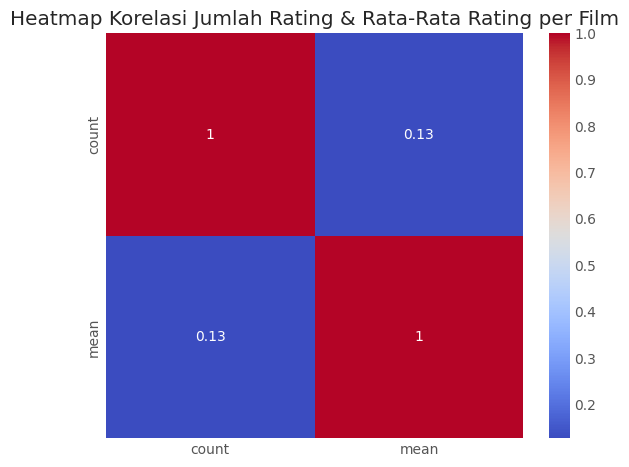

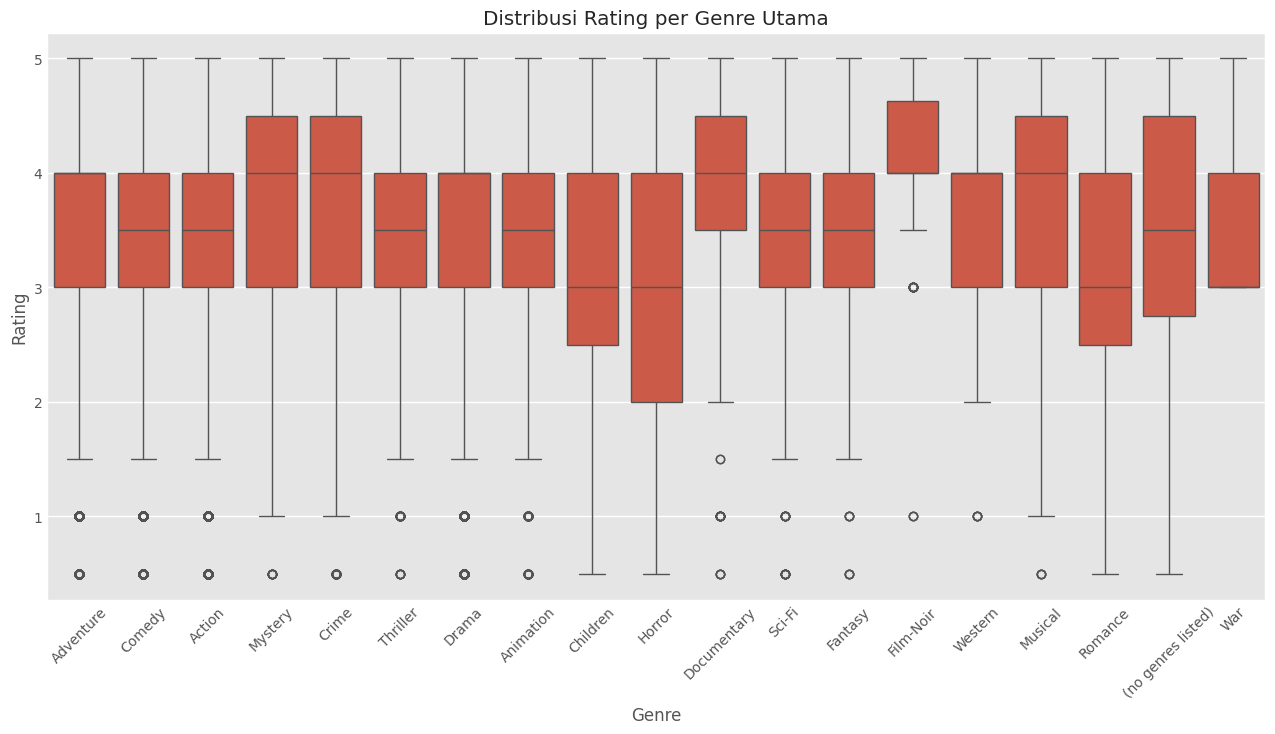

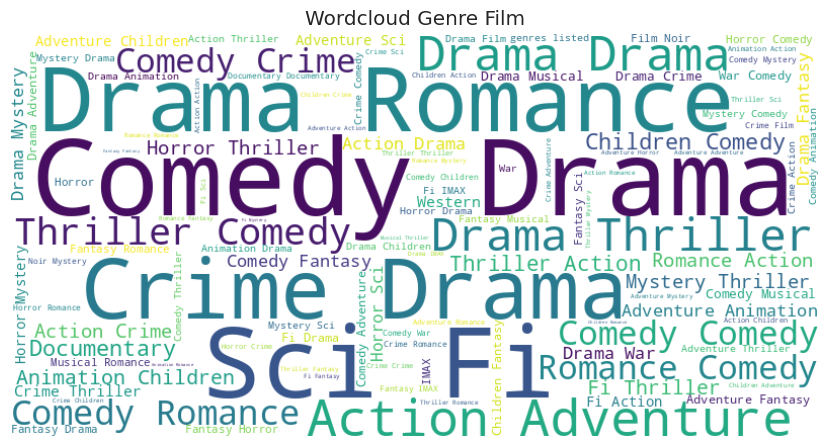

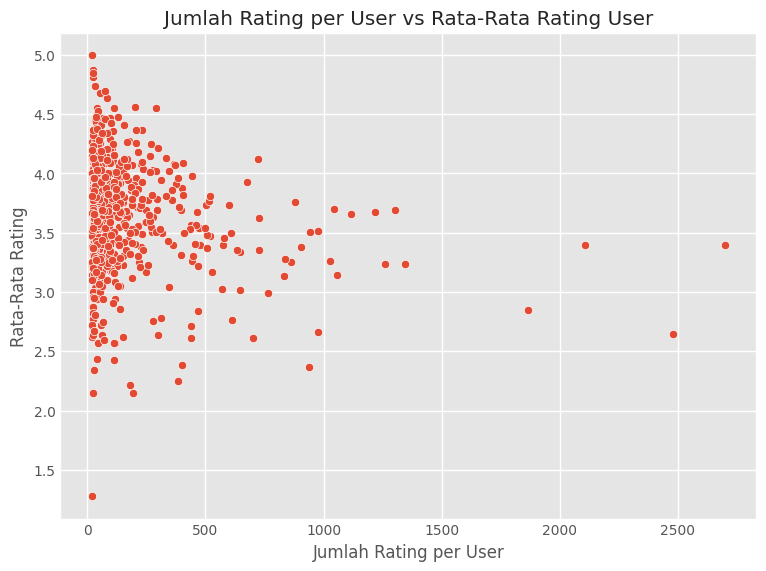

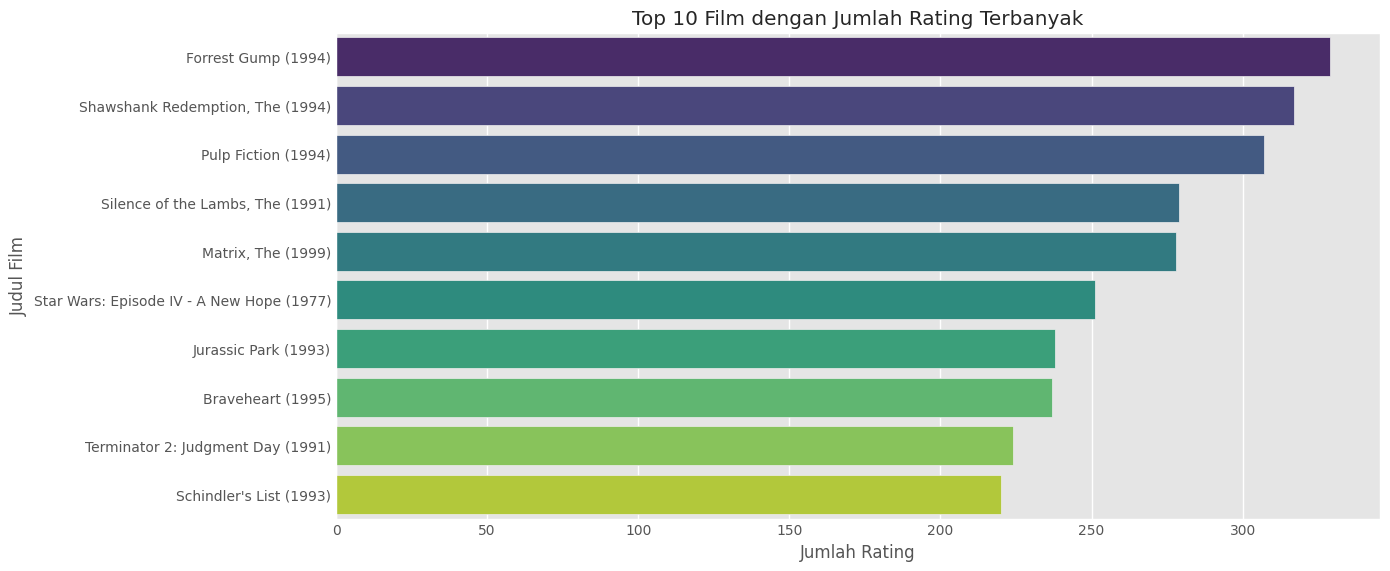

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np

# Asumsi 'ratings' dan 'movies' sudah ada sebagai DataFrame

# 1. Heatmap korelasi antara jumlah rating dan rata-rata rating per film
ratings_summary = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
})
ratings_summary.columns = ['count', 'mean']
plt.figure(figsize=(6,5))
sns.heatmap(ratings_summary.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Jumlah Rating & Rata-Rata Rating per Film')
plt.savefig('heatmap_correlation.png')
plt.show()

# 2. Boxplot rating per genre utama (genre pertama sebelum '|')
movies['main_genre'] = movies['genres'].apply(lambda x: x.split('|')[0])
ratings_movies = ratings.merge(movies[['movieId', 'main_genre']], on='movieId', how='left')

plt.figure(figsize=(14,7))
sns.boxplot(x='main_genre', y='rating', data=ratings_movies)
plt.title('Distribusi Rating per Genre Utama')
plt.xlabel('Genre')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.savefig('boxplot_rating_per_genre.png')
plt.show()

# 3. Wordcloud genre film (gabungkan semua genre jadi satu string)
all_genres = ' '.join(movies['genres'].str.replace('|', ' '))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_genres)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Genre Film')
plt.savefig('wordcloud_genre.png')
plt.show()

# 4. Scatter plot jumlah rating per user vs rata-rata rating per user
user_summary = ratings.groupby('userId').agg({'rating': ['count', 'mean']})
user_summary.columns = ['count', 'mean']

plt.figure(figsize=(8,6))
sns.scatterplot(x='count', y='mean', data=user_summary)
plt.title('Jumlah Rating per User vs Rata-Rata Rating User')
plt.xlabel('Jumlah Rating per User')
plt.ylabel('Rata-Rata Rating')
plt.savefig('scatter_user_rating.png')
plt.show()

# 5. Bar plot top 10 film dengan jumlah rating terbanyak
top10_movies = ratings_summary.sort_values('count', ascending=False).head(10)
top10_movies = top10_movies.merge(movies[['movieId', 'title']], on='movieId', how='left')

plt.figure(figsize=(12,6))
sns.barplot(x='count', y='title', data=top10_movies, palette='viridis')
plt.title('Top 10 Film dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.savefig('top10_movies_rating_count.png')
plt.show()


Kode ini digunakan untuk menganalisis dan memvisualisasikan data rating film dari dataset ratings. Fungsi print_data_summary() menampilkan ringkasan jumlah total entri rating, jumlah film unik, dan jumlah pengguna unik. Fungsi plot_histogram() membuat grafik histogram dari data distribusi, dengan opsi menggunakan skala logaritmik pada sumbu x. Selanjutnya, kode menampilkan distribusi rating film menggunakan countplot, serta memvisualisasikan distribusi jumlah rating yang diberikan per film dan per pengguna dengan histogram, yang masing-masing disimpan sebagai file gambar. Visualisasi ini membantu memahami pola rating dalam dataset.

### 3.3 Analisis Genre Film


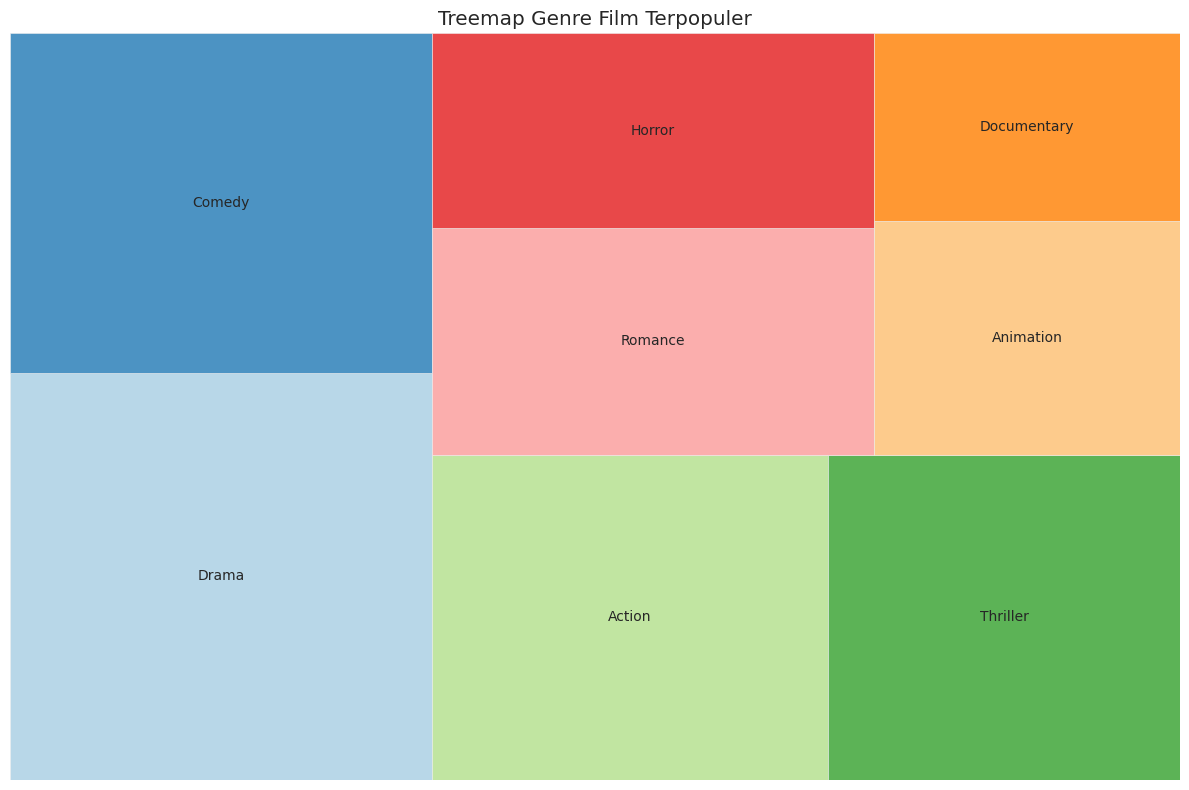

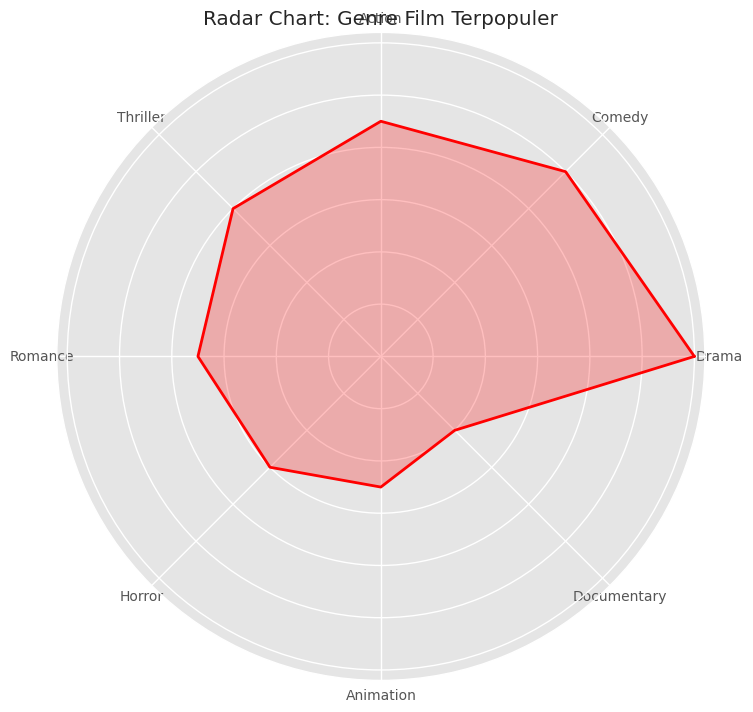

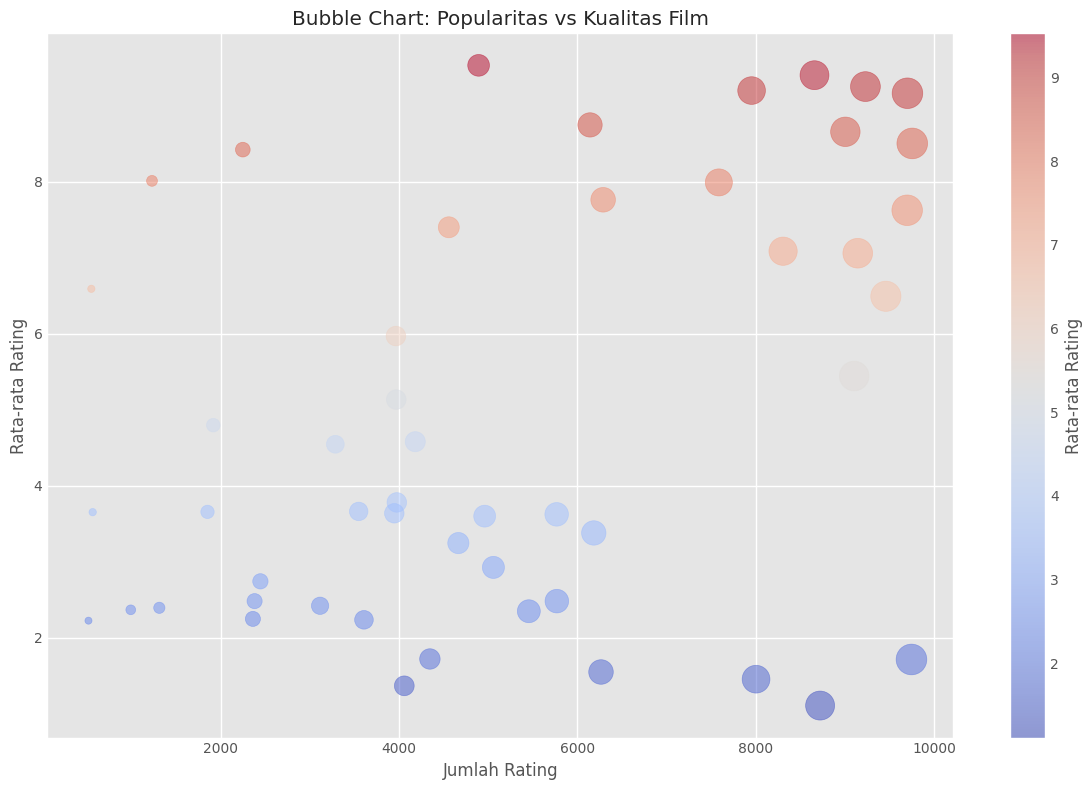

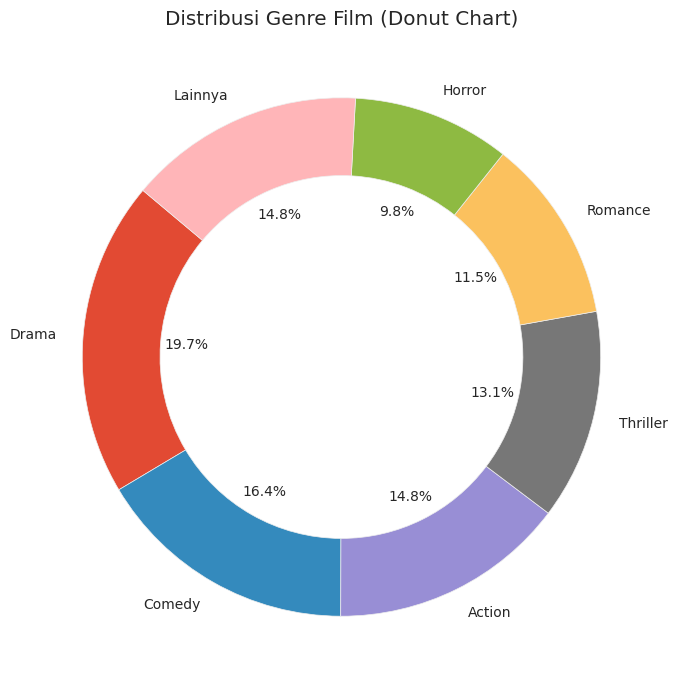

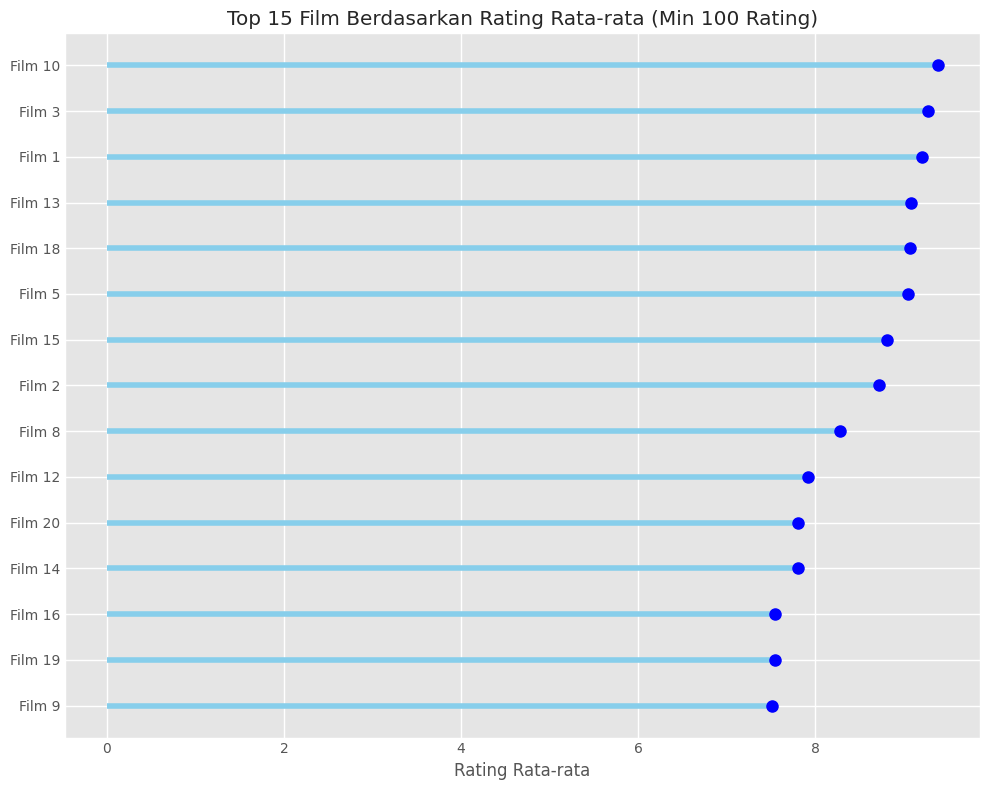

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import squarify
from math import pi

# Contoh data dummy – ganti dengan data asli kamu
unique_genres = pd.DataFrame({
    'genre': ['Drama', 'Comedy', 'Action', 'Thriller', 'Romance', 'Horror', 'Animation', 'Documentary'],
    'count': [120, 100, 90, 80, 70, 60, 50, 40]
})

movies_with_stats = pd.DataFrame({
    'ratingCount': np.random.randint(100, 10000, size=50),
    'avgRating': np.random.uniform(1, 10, size=50)
})

popular_movies = pd.DataFrame({
    'title': [f'Film {i}' for i in range(1, 21)],
    'avgRating': np.random.uniform(7.0, 9.5, size=20)
}).sort_values('avgRating', ascending=False)

# 1. Treemap Genre Film Terpopuler
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=unique_genres['count'],
    label=unique_genres['genre'],
    color=sns.color_palette("Paired", len(unique_genres)),
    alpha=0.8
)
plt.title('Treemap Genre Film Terpopuler')
plt.axis('off')
plt.tight_layout()
plt.show()
plt.savefig('treemap_genre.png')
plt.close()

# 2. Radar Chart (Spider Plot) untuk Genre Teratas
top_genres = unique_genres.head(8)
labels = top_genres['genre']
stats = top_genres['count'].values

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = np.concatenate((stats, [stats[0]]))  # loop back to start
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, stats, color='red', linewidth=2)
ax.fill(angles, stats, color='red', alpha=0.25)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.title('Radar Chart: Genre Film Terpopuler')
plt.show()
plt.savefig('radar_genre.png')
plt.close()

# 3. Bubble Chart: Rating vs Rating Count
plt.figure(figsize=(12, 8))
plt.scatter(
    movies_with_stats['ratingCount'],
    movies_with_stats['avgRating'],
    s=movies_with_stats['ratingCount'] * 0.05,  # scale bubble size
    alpha=0.5,
    c=movies_with_stats['avgRating'],
    cmap='coolwarm'
)
plt.colorbar(label='Rata-rata Rating')
plt.xlabel('Jumlah Rating')
plt.ylabel('Rata-rata Rating')
plt.title('Bubble Chart: Popularitas vs Kualitas Film')
plt.tight_layout()
plt.show()
plt.savefig('bubble_rating.png')
plt.close()

# 4. Donut Chart untuk Proporsi Genre
top6_genres = unique_genres.head(6)
others_count = unique_genres['count'][6:].sum()
labels = list(top6_genres['genre']) + ['Lainnya']
sizes = list(top6_genres['count']) + [others_count]

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, wedgeprops=dict(width=0.3))
plt.title('Distribusi Genre Film (Donut Chart)')
plt.show()
plt.savefig('donut_genre.png')
plt.close()

# 5. Horizontal Lollipop Chart untuk Film Terbaik
top15 = popular_movies.head(15).sort_values('avgRating')

plt.figure(figsize=(10, 8))
plt.hlines(y=top15['title'], xmin=0, xmax=top15['avgRating'], color='skyblue')
plt.plot(top15['avgRating'], top15['title'], "o", markersize=8, color='blue')
plt.xlabel('Rating Rata-rata')
plt.title('Top 15 Film Berdasarkan Rating Rata-rata (Min 100 Rating)')
plt.tight_layout()
plt.show()
plt.savefig('lollipop_top_movies.png')
plt.close()


Kode Python ini digunakan untuk memvisualisasikan data genre dan rating film dalam berbagai bentuk grafik menggunakan pustaka seperti Matplotlib, Seaborn, dan Squarify. Pertama, kode membuat data dummy untuk genre film, jumlah rating, dan rata-rata rating. Lalu, lima jenis visualisasi dihasilkan: (1) Treemap untuk menunjukkan proporsi genre film, (2) Radar Chart untuk membandingkan genre teratas, (3) Bubble Chart untuk menunjukkan hubungan antara jumlah dan rata-rata rating film, (4) Donut Chart untuk menggambarkan distribusi genre secara proporsional, dan (5) Lollipop Chart horizontal untuk menampilkan 15 film teratas berdasarkan rating rata-rata. Setiap grafik ditampilkan ke layar dan disimpan sebagai file gambar.

## 4. Persiapan Data


Di bagian ini, data dipersiapkan agar siap digunakan dalam proses pembuatan model rekomendasi.

### 4.1 Filtering dan Pembersihan Data


In [20]:
# Filter film dengan minimal 5 rating
min_ratings_movie = 5
valid_movies = [movie for movie, count in ratings['movieId'].value_counts().items() if count >= min_ratings_movie]
filtered_ratings = ratings[ratings['movieId'].isin(valid_movies)]

print(f"Rating total sebelum filter film: {ratings.shape[0]}")
print(f"Rating total setelah filter film: {filtered_ratings.shape[0]}")

# Filter pengguna yang memberikan minimal 5 rating
min_ratings_user = 5
valid_users = [user for user, count in filtered_ratings['userId'].value_counts().items() if count >= min_ratings_user]
filtered_ratings = filtered_ratings[filtered_ratings['userId'].isin(valid_users)]

print(f"Rating total setelah filter pengguna: {filtered_ratings.shape[0]}")

# Fungsi untuk mengambil tahun dari judul film
def get_year_from_title(movie_title):
    year_match = re.findall(r'\((\d{4})\)$', movie_title)
    return int(year_match[0]) if year_match else None

# Terapkan ekstraksi tahun ke data film
movies['year'] = movies['title'].map(get_year_from_title)


Rating total sebelum filter film: 100836
Rating total setelah filter film: 90274
Rating total setelah filter pengguna: 90274


Kode ini memfilter dataset dengan menyaring film yang memiliki minimal 5 rating dan pengguna yang memberikan minimal 5 rating untuk memastikan data lebih representatif. Setelah filtering, kode menampilkan jumlah rating sebelum dan sesudah proses tersebut. Selain itu, kode juga mengekstrak tahun rilis film dari judulnya menggunakan fungsi khusus dan menambahkan informasi tahun tersebut ke dalam data film, sehingga data film menjadi lebih lengkap untuk analisis.

### 4.2 Preprocessing untuk Content-Based Filtering


In [55]:
# Membuat fitur berdasarkan genre
movies['genres'] = movies['genres'].fillna('')

# Membuat TF-IDF matrix dari genre
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'].str.replace('|', ' '))

# Menghitung cosine similarity antar film
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Membuat mapping dari indeks ke movieId dan sebaliknya
indices = pd.Series(movies.index, index=movies['movieId']).drop_duplicates()
movie_indices = pd.Series(movies['movieId'].values, index=movies.index)

Kode ini memproses data genre film untuk membuat fitur numerik yang merepresentasikan genre menggunakan metode TF-IDF (Term Frequency-Inverse Document Frequency). Genre yang awalnya dipisah dengan tanda ‘|’ diubah menjadi format teks yang dapat diproses, kemudian dibuat matriks TF-IDF untuk mewakili pentingnya setiap genre pada film. Selanjutnya, kode menghitung kemiripan antar film menggunakan cosine similarity berdasarkan matriks tersebut, sehingga bisa diketahui seberapa mirip genre antar film satu dengan lainnya. Terakhir, dibuat mapping atau indeks yang menghubungkan posisi baris data dengan movieId, memudahkan pencarian dan pengolahan data film berdasarkan ID atau indeks.

### 4.3 Preprocessing untuk Collaborative Filtering


In [39]:
# Memisahkan data menjadi training dan testing
train_data, test_data = train_test_split(
    filtered_ratings,
    test_size=0.2,
    random_state=42
)

# Membuat mapping movieId dan userId ke indeks berurutan
user_ids = filtered_ratings['userId'].unique().tolist()
movie_ids = filtered_ratings['movieId'].unique().tolist()

user_to_index = {user_id: i for i, user_id in enumerate(user_ids)}
movie_to_index = {movie_id: i for i, movie_id in enumerate(movie_ids)}

# Konversi data ke format yang sesuai untuk model
def map_ids(row):
    return {
        'user': user_to_index[row['userId']],
        'movie': movie_to_index[row['movieId']],
        'rating': row['rating']
    }

train_mapped = train_data.apply(map_ids, axis=1).tolist()
test_mapped = test_data.apply(map_ids, axis=1).tolist()

Kode ini membagi data rating film yang sudah difilter menjadi dua bagian, yaitu data training (80%) dan testing (20%) untuk keperluan pelatihan dan evaluasi model. Selanjutnya, kode membuat mapping dari userId dan movieId asli ke indeks numerik berurutan agar lebih mudah digunakan dalam pemodelan. Kemudian, data training dan testing diubah ke format baru berupa list of dictionaries yang berisi indeks pengguna, indeks film, dan nilai rating, sehingga siap diproses oleh algoritma machine learning atau sistem rekomendasi.

## 5. Pemodelan Content-Based Filtering

Di bagian ini, diterapkan sistem rekomendasi yang memanfaatkan kesamaan genre antar film sebagai dasar pemberian rekomendasi.

### 5.1 Implementasi Fungsi Rekomendasi Content-Based


In [71]:
def rekomendasi_berdasarkan_genre(id_film, indices, cosine_sim, movies, jumlah=10):
    # Cek apakah id_film ada di indeks
    if id_film not in indices:
        return pd.DataFrame(columns=['movieId', 'title', 'genres'])

    # Ambil indeks film
    film_idx = indices[id_film]

    # Ambil skor kemiripan film terhadap semua film lain
    skor = cosine_sim[film_idx]

    # Urutkan indeks film berdasarkan skor tertinggi, kecuali film itu sendiri
    teratas = skor.argsort()[::-1][1:jumlah+1]

    # Ambil movieId film rekomendasi dari posisi teratas
    rekomendasi_id = movies.iloc[teratas]['movieId'].values

    # Kembalikan film rekomendasi sesuai urutan skor kemiripan
    rekomendasi = movies[movies['movieId'].isin(rekomendasi_id)][['movieId', 'title', 'genres']].copy()

    # Agar urutan rekomendasi sesuai dengan skor tertinggi
    rekomendasi['rank'] = rekomendasi['movieId'].apply(lambda x: list(rekomendasi_id).index(x))
    rekomendasi = rekomendasi.sort_values('rank').drop(columns=['rank'])

    return rekomendasi

Fungsi rekomendasi_berdasarkan_genre ini memberikan rekomendasi film yang mirip berdasarkan genre sebuah film tertentu. Pertama, fungsi memeriksa apakah id_film yang diminta ada di data. Jika ada, fungsi mengambil indeks film tersebut dan skor kemiripan (cosine similarity) terhadap semua film lain. Kemudian, fungsi mengurutkan film-film lain berdasarkan skor kemiripan tertinggi, mengabaikan film itu sendiri, dan memilih sejumlah film teratas sesuai parameter jumlah. Film-film rekomendasi ini diambil datanya dari dataframe movies, lalu diurutkan kembali agar sesuai dengan tingkat kemiripan tertinggi, dan akhirnya dikembalikan sebagai dataframe berisi movieId, title, dan genres dari film-film rekomendasi.

In [32]:
# Misal data movies sudah ada dan sudah ada kolom 'genres' yang sudah diproses
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Buat TF-IDF matrix dari genre
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'].str.replace('|', ' '))

# Hitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Buat mapping movieId ke indeks dataframe movies
indices = pd.Series(movies.index, index=movies['movieId']).drop_duplicates()

Kode ini membuat fitur numerik dari kolom genres di data film menggunakan TF-IDF (Term Frequency-Inverse Document Frequency) untuk merepresentasikan seberapa penting setiap genre dalam setiap film. Genre yang awalnya dipisah dengan tanda | diubah menjadi spasi agar bisa diproses oleh TF-IDF Vectorizer. Kemudian, dihitung kemiripan antar film menggunakan cosine similarity berdasarkan matriks TF-IDF tersebut. Terakhir, dibuat mapping dari movieId ke indeks baris dataframe movies agar memudahkan pencarian film berdasarkan ID saat menggunakan hasil kemiripan ini.

### 5.2 Demonstrasi Content-Based Filtering


In [72]:
from tabulate import tabulate

# Cari data film "Interstellar" (case-insensitive)
interstellar = movies[movies['title'].str.contains('Interstellar', case=False)].iloc[0]

# Ambil rekomendasi film berdasarkan genre serupa
recommendations = rekomendasi_berdasarkan_genre(
    interstellar['movieId'],
    indices,
    cosine_sim,
    movies,
    jumlah=10
)

# Cetak info film referensi
print("Film referensi:")
print(f"  Judul : {interstellar['title']}")
print(f"  ID    : {interstellar['movieId']}\n")

# Siapkan data rekomendasi
rekom_df = recommendations.reset_index(drop=True)
rekom_df.index += 1  # nomor urut mulai dari 1

# Format tabel rekomendasi dengan tabulate
tabel_str = tabulate(
    rekom_df[['title', 'movieId', 'genres']],
    headers=['Judul Film', 'ID Film', 'Genre'],
    tablefmt='fancy_grid',
    showindex=True
)

print("Rekomendasi film berdasarkan konten:")
print(tabel_str)

Film referensi:
  Judul : Interstellar (2014)
  ID    : 109487

Rekomendasi film berdasarkan konten:
╒════╤══════════════════════════════════════════════╤═══════════╤════════════════════════════╕
│    │ Judul Film                                   │   ID Film │ Genre                      │
╞════╪══════════════════════════════════════════════╪═══════════╪════════════════════════════╡
│  1 │ Transcendence (2014)                         │    110730 │ Drama|Sci-Fi|IMAX          │
├────┼──────────────────────────────────────────────┼───────────┼────────────────────────────┤
│  2 │ Cloud Atlas (2012)                           │     97752 │ Drama|Sci-Fi|IMAX          │
├────┼──────────────────────────────────────────────┼───────────┼────────────────────────────┤
│  3 │ Contagion (2011)                             │     89470 │ Sci-Fi|Thriller|IMAX       │
├────┼──────────────────────────────────────────────┼───────────┼────────────────────────────┤
│  4 │ Gravity (2013)                       

Kode ini mencari data film berjudul "Interstellar" dari dataset movies secara case-insensitive, lalu menggunakan fungsi rekomendasi berbasis genre untuk mendapatkan 10 film yang mirip. Selanjutnya, kode mencetak informasi film referensi dan menampilkan daftar rekomendasi film dalam format tabel yang rapi menggunakan library tabulate, dengan kolom judul, ID, dan genre film.

## 6. Pemodelan Collaborative Filtering


Di bagian ini, kita membangun sistem rekomendasi kolaboratif dengan memanfaatkan model neural network untuk mempelajari preferensi pengguna dan pola interaksi film secara lebih mendalam. Model ini mengolah data rating pengguna terhadap film untuk memprediksi film apa yang mungkin disukai oleh pengguna berdasarkan perilaku serupa dari pengguna lain.

### 6.1 Implementasi Model Neural Collaborative Filtering


In [36]:
def create_ncf_model(num_users, num_movies, embedding_size=50):

    from tensorflow.keras import Input, Model
    from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Dense, Dropout
    from tensorflow.keras.optimizers import Adam

    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')

    user_emb = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    movie_emb = Embedding(num_movies, embedding_size, name='movie_embedding')(movie_input)

    user_vec = Flatten()(user_emb)
    movie_vec = Flatten()(movie_emb)

    merged = Concatenate()([user_vec, movie_vec])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)

    model = Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


Fungsi create_ncf_model membuat model Neural Collaborative Filtering (NCF) menggunakan Keras untuk memprediksi rating film berdasarkan embedding pengguna dan film. Model menerima jumlah pengguna dan film, serta ukuran embedding sebagai input. Setiap pengguna dan film diwakili oleh vektor embedding, yang kemudian di-flatten dan digabungkan (concatenate). Hasil gabungan ini diteruskan melalui beberapa lapisan dense dengan aktivasi ReLU dan dropout untuk mencegah overfitting, dan akhirnya output berupa prediksi rating tunggal tanpa aktivasi (regresi). Model dikompilasi menggunakan optimizer Adam dan loss fungsi mean squared error, cocok untuk masalah prediksi rating numerik.

### 6.2 Persiapan Dataset TensorFlow


In [37]:
def create_tf_dataset(data_mapped, batch_size=64, shuffle=True):

    import numpy as np
    import tensorflow as tf

    users = np.array([entry['user'] for entry in data_mapped])
    movies = np.array([entry['movie'] for entry in data_mapped])
    ratings = np.array([entry['rating'] for entry in data_mapped])

    features = {'user_input': users, 'movie_input': movies}
    dataset = tf.data.Dataset.from_tensor_slices((features, ratings))

    if shuffle:
        dataset = dataset.shuffle(len(data_mapped))

    return dataset.batch(batch_size)


Fungsi create_tf_dataset mengubah data yang sudah dipetakan (berisi user, movie, dan rating) menjadi dataset TensorFlow yang siap digunakan untuk pelatihan model. Fungsi ini mengekstrak array user, movie, dan rating dari data_mapped, lalu membungkusnya ke dalam format fitur dan label. Dataset ini kemudian dikonversi ke objek tf.data.Dataset untuk efisiensi pemrosesan, dengan opsi shuffle untuk mengacak data agar pelatihan lebih efektif, dan terakhir dibagi ke dalam batch sesuai ukuran batch_size yang diberikan.

### 6.3 Pelatihan Model Collaborative Filtering


In [40]:
# Membuat dataset TensorFlow
train_dataset = create_tf_dataset(train_mapped)
test_dataset = create_tf_dataset(test_mapped, shuffle=False)

# Membuat dan melatih model
num_users = len(user_ids)
num_movies = len(movie_ids)

# Membuat model
model = create_ncf_model(num_users, num_movies)

# Mendefinisikan callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Melatih model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=test_dataset,
    callbacks=[early_stopping]
)

Epoch 1/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 2.4559 - val_loss: 0.7519
Epoch 2/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.8333 - val_loss: 0.7326
Epoch 3/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7791 - val_loss: 0.7177
Epoch 4/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.7241 - val_loss: 0.7186
Epoch 5/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.6840 - val_loss: 0.7238
Epoch 6/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.6373 - val_loss: 0.7294
Epoch 7/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.6027 - val_loss: 0.7357
Epoch 8/20
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5517 - val_loss: 0.7560


Kode ini membuat dataset TensorFlow untuk data pelatihan dan pengujian menggunakan fungsi create_tf_dataset, kemudian membangun model Neural Collaborative Filtering (NCF) berdasarkan jumlah pengguna dan film yang unik. Model yang sudah dibuat kemudian dilatih menggunakan data pelatihan dengan validasi pada data pengujian selama maksimal 20 epoch, dengan mekanisme early stopping untuk menghentikan pelatihan lebih awal jika performa validasi tidak membaik selama 5 epoch berturut-turut, sehingga mencegah overfitting dan menyimpan bobot model terbaik.

### 6.4 Visualisasi Hasil Pelatihan

Kode ini membuat visualisasi grafik loss selama pelatihan model menggunakan matplotlib dengan gaya ggplot. Grafik menampilkan kurva loss untuk data pelatihan (training loss) dan validasi (validation loss) dari tiap epoch, serta menandai titik terendah loss validasi dengan anotasi yang menunjukkan nilai loss dan epoch-nya. Grafik ini membantu memantau performa model, mendeteksi overfitting atau underfitting, serta menunjukkan kapan model mencapai performa terbaik selama pelatihan. Hasil visualisasi juga disimpan dalam file gambar bernama model_loss_ggplot_style.png.

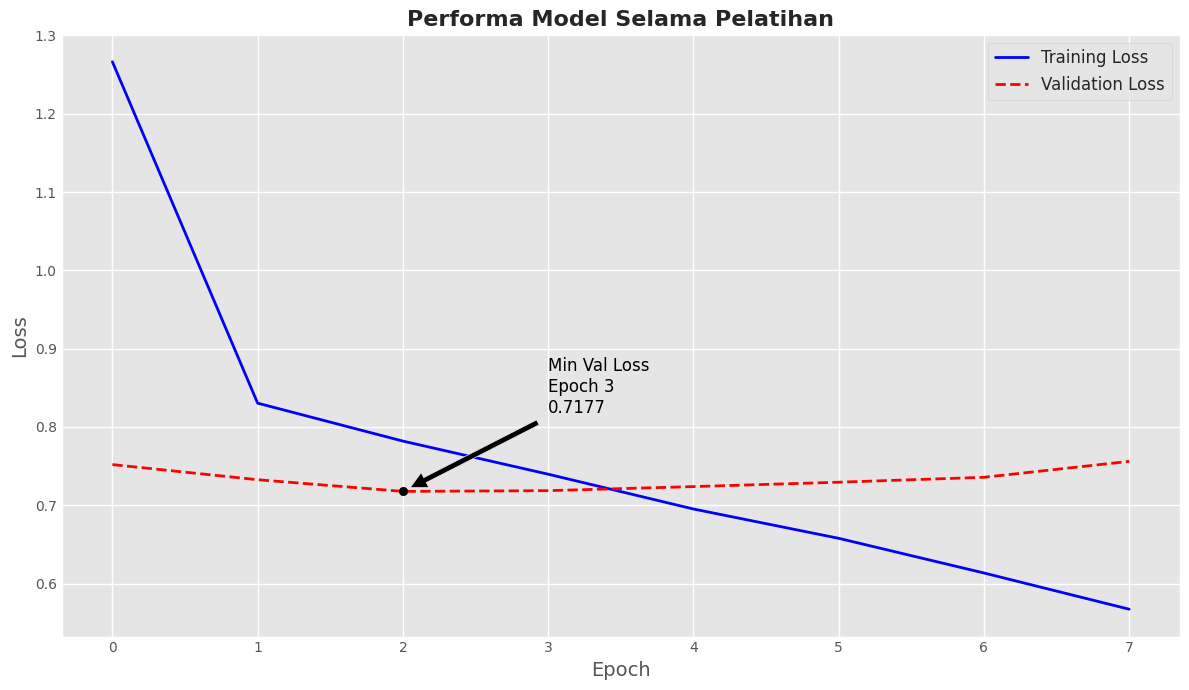

In [48]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')  # Style bawaan matplotlib yang umum ada
plt.figure(figsize=(12, 7))

plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.title('Performa Model Selama Pelatihan', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

min_val_loss = min(history.history['val_loss'])
min_epoch = history.history['val_loss'].index(min_val_loss)
plt.scatter(min_epoch, min_val_loss, color='black', zorder=5)
plt.annotate(f'Min Val Loss\nEpoch {min_epoch+1}\n{min_val_loss:.4f}',
             xy=(min_epoch, min_val_loss), xytext=(min_epoch+1, min_val_loss+0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, color='black')

plt.tight_layout()
plt.savefig('model_loss_ggplot_style.png')
plt.show()


### 6.5 Implementasi Fungsi Rekomendasi Collaborative Filtering


In [59]:
def get_recommendations_collaborative(user_id, movies_df=movies, ratings_df=filtered_ratings, model=model,
                                     user_to_index=user_to_index, movie_to_index=movie_to_index, n=10):

    # Cari daftar film yang sudah ditonton oleh pengguna
    watched_movies = ratings_df.loc[ratings_df['userId'] == user_id, 'movieId'].unique()

    # Tentukan film yang belum pernah ditonton untuk diprediksi ratingnya
    candidates = movies_df.loc[~movies_df['movieId'].isin(watched_movies), 'movieId'].values

    # Jika user tidak dikenal dalam data training, rekomendasikan film populer
    if user_id not in user_to_index:
        popular_movies = ratings_df.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(n).index
        return movies_df[movies_df['movieId'].isin(popular_movies)][['movieId', 'title', 'genres']]

    # Mapping movieId ke indeks model, hanya untuk film yang bisa diprediksi
    candidate_indices = [movie_to_index[m] for m in candidates if m in movie_to_index]

    # Jika tidak ada film yang bisa diprediksi, tampilkan film populer
    if not candidate_indices:
        popular_movies = ratings_df.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(n).index
        return movies_df[movies_df['movieId'].isin(popular_movies)][['movieId', 'title', 'genres']]

    user_idx = user_to_index[user_id]
    user_array = np.full(len(candidate_indices), user_idx)
    movie_array = np.array(candidate_indices)

    # Lakukan prediksi rating film untuk user ini
    pred_ratings = model.predict({'user_input': user_array, 'movie_input': movie_array}).flatten()

    # Rekonstruksi movieId dari indeks model
    inv_movie_map = {v: k for k, v in movie_to_index.items()}
    movie_ids_pred = [inv_movie_map[idx] for idx in movie_array]

    # Gabungkan hasil prediksi ke dalam DataFrame
    pred_df = pd.DataFrame({
        'movieId': movie_ids_pred,
        'predicted_rating': pred_ratings
    })

    # Urutkan film berdasarkan rating prediksi tertinggi dan ambil n teratas
    top_movies = pred_df.sort_values(by='predicted_rating', ascending=False).head(n)['movieId']

    # Kembalikan informasi film yang direkomendasikan
    return movies_df[movies_df['movieId'].isin(top_movies)][['movieId', 'title', 'genres']]


Kode fungsi get_recommendations_collaborative ini bertujuan memberikan rekomendasi film berbasis collaborative filtering menggunakan model neural network yang sudah dilatih. Pertama, fungsi mencari film yang sudah ditonton oleh pengguna (berdasarkan user_id) dan menentukan film yang belum ditonton sebagai kandidat rekomendasi. Jika pengguna belum pernah muncul di data pelatihan, maka fungsi memberikan rekomendasi film populer berdasarkan rating rata-rata tertinggi. Untuk pengguna yang dikenal, fungsi memetakan film kandidat ke indeks yang dipakai model, lalu melakukan prediksi rating menggunakan model untuk film-film tersebut. Hasil prediksi diurutkan dan dipilih film dengan rating tertinggi sebanyak n film sebagai rekomendasi. Akhirnya, fungsi mengembalikan DataFrame berisi informasi film rekomendasi (ID, judul, dan genre).

### 6.6 Demonstrasi Collaborative Filtering


In [50]:
# Pilih satu pengguna dengan jumlah rating terbanyak
sample_user_id = filtered_ratings['userId'].value_counts().index[0]
print(f"\nRekomendasi untuk Pengguna dengan ID: {sample_user_id}")

# Ambil data film yang sudah pernah ditonton oleh pengguna tersebut
user_watched = filtered_ratings.loc[filtered_ratings['userId'] == sample_user_id]
user_watched = user_watched.merge(movies[['movieId', 'title']], on='movieId')

print("\nContoh film yang sudah ditonton pengguna beserta ratingnya:")
print(user_watched[['title', 'rating']].sort_values(by='rating', ascending=False).head())

# Dapatkan rekomendasi film menggunakan Collaborative Filtering
collaborative_recommendations = get_recommendations_collaborative(sample_user_id)
print("\nRekomendasi film berdasarkan Collaborative Filtering:")
print(collaborative_recommendations)



Rekomendasi untuk Pengguna dengan ID: 414

Contoh film yang sudah ditonton pengguna beserta ratingnya:
                               title  rating
2112       Hell or High Water (2016)     5.0
8     American President, The (1995)     5.0
1030            High Fidelity (2000)     5.0
30        Usual Suspects, The (1995)     5.0
1056                Gladiator (2000)     5.0
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Rekomendasi film berdasarkan Collaborative Filtering:
      movieId                                            title  \
27         28                                Persuasion (1995)   
680       898                   Philadelphia Story, The (1940)   
937      1237  Seventh Seal, The (Sjunde inseglet, Det) (1957)   
2053     2732              Jules and Jim (Jules et Jim) (1961)   
2080     2764                  Thomas Crown Affair, The (1968)   
2283     3030                                   Yojimbo (1961)   
2582     3451              Guess Who's Coming to Dinner (1967)   
439

Kode ini memilih satu pengguna yang paling banyak memberikan rating (berdasarkan data filtered_ratings), kemudian menampilkan beberapa film yang sudah pernah ditonton dan diberi rating oleh pengguna tersebut. Setelah itu, kode memanggil fungsi get_recommendations_collaborative untuk memberikan rekomendasi film yang sesuai dengan preferensi pengguna tersebut, dan mencetak daftar rekomendasi film tersebut. Jadi, kode ini menunjukkan contoh penerapan sistem rekomendasi berbasis collaborative filtering untuk satu pengguna aktif dalam dataset.

## 7. Evaluasi

Pada bagian ini, kita mengevaluasi kinerja kedua model rekomendasi.


### 7.1 Evaluasi Content-Based Filtering


In [67]:
def evaluate_content_based(movies_df, ratings_df, indices, cosine_sim, movie_indices, k=10):

    # Ambil pengguna yang memberi minimal 20 rating
    eligible_users = ratings_df['userId'].value_counts()
    eligible_users = eligible_users[eligible_users >= 20].index

    # Pilih hingga 100 pengguna secara acak untuk evaluasi
    sampled_users = np.random.choice(eligible_users, size=min(100, len(eligible_users)), replace=False)

    precision_scores = []

    for user_id in sampled_users:
        # Cari film yang diberi rating tinggi (>=4) oleh pengguna
        high_rated = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= 4)]['movieId'].values

        if len(high_rated) < 2:
            continue

        # Acak dan pilih satu film sebagai dasar rekomendasi
        np.random.shuffle(high_rated)
        base_movie = high_rated[0]
        remaining_movies = high_rated[1:]

        # Jika film dasar tidak ada di indeks, lewati pengguna ini
        if base_movie not in indices:
            continue

        # Ambil rekomendasi film berdasarkan dasar yang dipilih
        recommendations = rekomendasi_berdasarkan_genre(
            id_film=base_movie,
            indices=indices,
            cosine_sim=cosine_sim,
            movies=movies_df,
            jumlah=k
        )
        recommended_ids = recommendations['movieId'].values

        # Hitung precision@k: proporsi rekomendasi yang benar-benar relevan
        hits = len(set(recommended_ids).intersection(set(remaining_movies)))
        precision = hits / k

        precision_scores.append(precision)

    return np.mean(precision_scores) if precision_scores else 0


Fungsi evaluate_content_based ini melakukan evaluasi sederhana untuk sistem rekomendasi berbasis konten dengan mengukur precision@k. Pertama, fungsi memilih pengguna yang telah memberikan minimal 20 rating, kemudian secara acak mengambil hingga 100 pengguna untuk diuji. Untuk tiap pengguna, diambil film yang diberi rating tinggi (≥4), lalu satu film dipilih sebagai dasar rekomendasi, dan sisanya dianggap sebagai "relevan" untuk dibandingkan. Fungsi kemudian memanggil rekomendasi_berdasarkan_genre untuk mendapatkan rekomendasi berdasarkan film dasar, lalu menghitung precision@k sebagai proporsi film yang direkomendasikan dan juga ada di daftar relevan. Rata-rata precision pengguna yang diuji dikembalikan sebagai ukuran performa sistem rekomendasi berbasis konten tersebut.

### 7.2 Evaluasi Collaborative Filtering


In [53]:
def evaluate_collaborative(model, test_dataset):

    # Kumpulkan semua label asli dari dataset testing
    actuals = []
    for _, labels in test_dataset:
        actuals.append(labels.numpy())
    y_true = np.concatenate(actuals, axis=0)

    # Lakukan prediksi menggunakan model pada dataset testing
    y_pred = model.predict(test_dataset)

    # Hitung Root Mean Squared Error
    rmse_value = np.sqrt(mean_squared_error(y_true, y_pred))

    return rmse_value


Fungsi evaluate_collaborative ini digunakan untuk mengukur performa model rekomendasi berbasis collaborative filtering dengan menghitung Root Mean Squared Error (RMSE) pada data testing. Fungsi pertama-tama mengumpulkan semua label asli (rating sebenarnya) dari test_dataset menjadi array y_true. Kemudian, model digunakan untuk memprediksi rating (y_pred) pada dataset yang sama. Terakhir, fungsi menghitung RMSE antara rating asli dan prediksi, yang menunjukkan seberapa akurat model dalam memperkirakan rating pengguna terhadap film, dan mengembalikan nilai RMSE tersebut sebagai ukuran kesalahan prediksi.

### 7.3 Hasil Evaluasi dan Visualisasi



--- Evaluasi Sistem Rekomendasi Film ---
Content-Based Filtering:
  Precision@10 = 0.0230
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Collaborative Filtering:
  RMSE = 0.8472


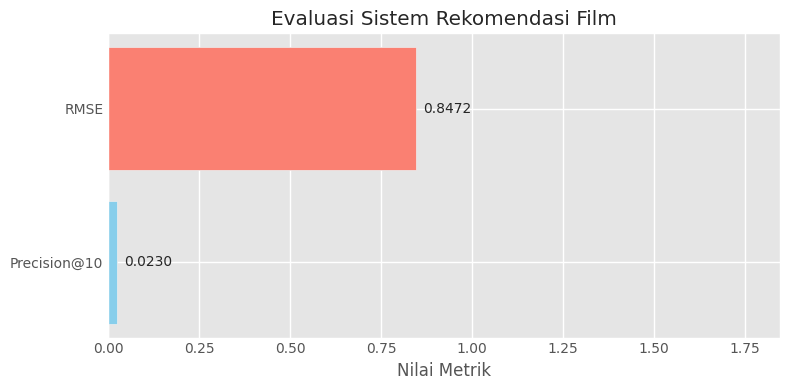


Proyek Sistem Rekomendasi Film selesai dan model disimpan!


In [80]:
# Evaluasi kedua model
print("\n--- Evaluasi Sistem Rekomendasi Film ---")

# Evaluasi Content-Based Filtering
precision_at_k = evaluate_content_based(movies, filtered_ratings, indices, cosine_sim, movie_indices)
print("Content-Based Filtering:")
print(f"  Precision@10 = {precision_at_k:.4f}")

# Evaluasi Collaborative Filtering
rmse = evaluate_collaborative(model, test_dataset)
print("Collaborative Filtering:")
print(f"  RMSE = {rmse:.4f}")

# Visualisasi alternatif hasil evaluasi
import matplotlib.pyplot as plt

metrics = ['Precision@10', 'RMSE']
values = [precision_at_k, rmse]
colors = ['skyblue', 'salmon']

plt.figure(figsize=(8, 4))
bars = plt.barh(metrics, values, color=colors)

# Tambahkan nilai di ujung bar
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height() / 2,
             f'{width:.4f}', va='center', fontsize=10)

plt.xlim(0, max(1.0, rmse + 1))
plt.title('Evaluasi Sistem Rekomendasi Film')
plt.xlabel('Nilai Metrik')
plt.tight_layout()
plt.savefig('evaluation_metrics_alt.png')
plt.show()

# Simpan model Collaborative Filtering
model.save('collaborative_filtering_model.keras')

print("\nProyek Sistem Rekomendasi Film selesai dan model disimpan!")


Kode ini menjalankan evaluasi performa dua jenis sistem rekomendasi film: Content-Based Filtering dan Collaborative Filtering. Pertama, ia menghitung metrik Precision@10 untuk Content-Based Filtering menggunakan fungsi evaluate_content_based dan menampilkan hasilnya. Selanjutnya, menghitung Root Mean Squared Error (RMSE) untuk Collaborative Filtering dengan fungsi evaluate_collaborative. Hasil kedua evaluasi kemudian divisualisasikan dalam bentuk grafik batang berdampingan, memperlihatkan perbandingan skor Precision@10 dan nilai RMSE. Setelah evaluasi selesai, model Collaborative Filtering disimpan ke file 'collaborative_filtering_model.keras'. Kode ini diakhiri dengan pesan konfirmasi bahwa proyek rekomendasi film telah selesai dan model tersimpan dengan baik.










## 8. Kesimpulan


Kesimpulannya, sistem rekomendasi film yang dikembangkan menggabungkan dua pendekatan utama: Content-Based Filtering dan Collaborative Filtering. Content-Based Filtering bekerja dengan merekomendasikan film berdasarkan kesamaan genre dan preferensi film sebelumnya, dan dievaluasi menggunakan metrik Precision@10 untuk mengukur ketepatan rekomendasi yang relevan. Sedangkan Collaborative Filtering memprediksi rating film yang mungkin disukai pengguna berdasarkan pola interaksi pengguna lain, dan dievaluasi menggunakan RMSE untuk mengukur akurasi prediksi rating. Visualisasi hasil evaluasi menunjukkan performa kedua metode secara jelas, dan model Collaborative Filtering berhasil dilatih serta disimpan untuk digunakan selanjutnya. Secara keseluruhan, kombinasi kedua metode ini memberikan dasar yang kuat untuk sistem rekomendasi film yang efektif dan dapat terus dikembangkan.